In [4]:
#This code is based on several resources including tutorials by Sentinel Hub, EOlearn.

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# data manipulation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# image manipulations
from skimage.filters import threshold_otsu, sobel
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk

# GIS related
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import shape, MultiPolygon, Polygon

# eo-learn related
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType

# We'll use Sentinel-2 imagery (Level-1C) provided through Sentinel Hub

from eolearn.io.processing_api import SentinelHubInputTask
from eolearn.core import LoadFromDisk, SaveToDisk

from eolearn.mask import AddValidDataMaskTask

# filtering of scenes
from eolearn.features import SimpleFilterTask, NormalizedDifferenceIndexTask

# burning the vectorised polygon to raster
from eolearn.geometry import VectorToRaster

# Sentinel Hub
from sentinelhub import BBox, CRS
from sentinelhub.data_request import WmsRequest, WcsRequest
from sentinelhub.constants import MimeType

In [5]:
import urllib.request as request
import json
import shapely.wkt
from datetime import datetime
from shapely.wkt import loads
from shapely.geometry import Polygon

# sentinelhub-py package
from sentinelhub import BBox, CRS, DataSource

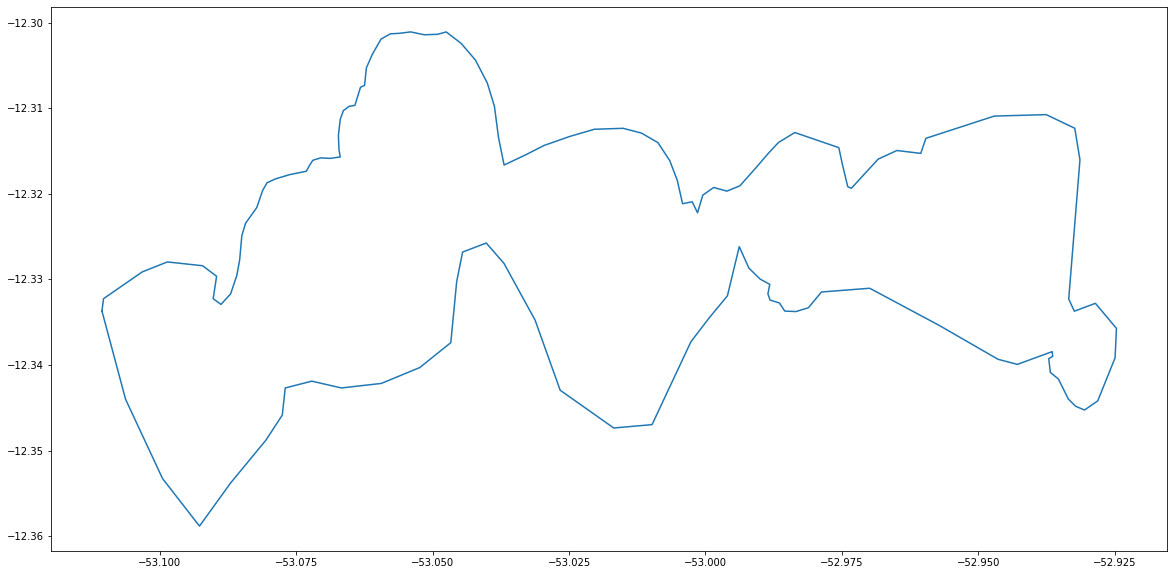

In [6]:
ID = 16803 #Lagoa do Itafununu
#ID = 18425 #granbury
#ID = 18420 #tyler
#ID = 18430 # lyndon b jhonson
#ID = 18337 #navarro mills, usa
#ID = 18292 #lake buchanan, usa
#ID = 18295 #lake tawakoni
#ID = 20093 #buendia dam
#ID = 38102 #al massira, morocco
#ID = 9976 #lake assal, djibouti
#ID = 36966 #Great Salt Lake (United States of America)
#ID = 18349 #lake limestone
#ID = 8332 #Tippagondanahalli Reservoir, bangalore
#ID = 7136 # osman sagar, hyderabad


# function for obtaining the nominal water geometry from the water observatory API
def get_nominal_geometry(ID):
    wb_url = f'https://water.blue-dot-observatory.com/api/waterbodies/{ID}/index.html'
    with request.urlopen(wb_url) as url:
        wb_data = json.loads(url.read().decode())
        nominal_outline = shape(wb_data['nominal_outline']['geometry'])
    return nominal_outline

def plot_geometry(geom, ax = None, **kwargs):
    
    if geom is None:
        return
    if geom.exterior is None:
        return
    
    x,y = geom.exterior.xy

    if ax is None:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111)

        
    ax.plot(x, y, **kwargs)
    
# get the nominal geometry
geom = get_nominal_geometry(ID)

# and plot it
plot_geometry(geom)


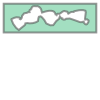

In [7]:
inflate_bbox = 0.1
minx, miny, maxx, maxy = geom.bounds
delx = maxx - minx
dely = maxy - miny
minx = minx - delx * inflate_bbox
maxx = maxx + delx * inflate_bbox
miny = miny - dely * inflate_bbox
maxy = maxy + dely * inflate_bbox
dam_bbox = BBox([minx, miny, maxx, maxy], crs=CRS.WGS84)

dam_bbox.geometry - geom


In [8]:
download_task = SentinelHubInputTask(data_source=DataSource.SENTINEL2_L1C, 
                                     bands_feature=(FeatureType.DATA, 'BANDS'),
                                     resolution=20, 
                                     maxcc=0.5, 
                                     bands=['B02', 'B03', 'B04', 'B08', 'B11', 'B12'], 
                                     additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'), (FeatureType.MASK, 'CLM')]
                                    )

calculate_ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'), (1, 3))

dam_gdf = gpd.GeoDataFrame(crs=CRS.WGS84.pyproj_crs(), geometry=[geom])

<Figure size 1440x720 with 0 Axes>

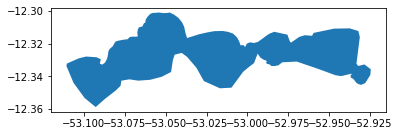

In [9]:
fig = plt.figure(figsize=(20,10))
dam_gdf.plot();

In [10]:
add_nominal_water = VectorToRaster(dam_gdf, (FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), values=1, 
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), raster_dtype=np.uint8)

In [11]:
def calculate_valid_data_mask(eopatch):
    is_data_mask = eopatch.mask['IS_DATA'].astype(np.bool)
    cloud_mask = ~eopatch.mask['CLM'].astype(np.bool)
    return np.logical_and(is_data_mask, cloud_mask)

add_valid_mask = AddValidDataMaskTask(predicate=calculate_valid_data_mask)

In [12]:
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

class AddValidDataCoverage(EOTask):
    
    def execute(self, eopatch):
        
        valid_data = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        time, height, width, channels = valid_data.shape
        
        coverage = np.apply_along_axis(calculate_coverage, 1,
                                       valid_data.reshape((time, height * width * channels)))
        
        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
        return eopatch
    
add_coverage = AddValidDataCoverage()

In [13]:
cloud_coverage_threshold = 0.05 

class ValidDataCoveragePredicate:
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        return calculate_coverage(array) < self.threshold
    
remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'),
                                        ValidDataCoveragePredicate(cloud_coverage_threshold))

In [14]:
class WaterDetector(EOTask):
    
    @staticmethod
    def detect_water(ndwi):
        otsu_thr = 1.0
        if len(np.unique(ndwi)) > 1:
            ndwi[np.isnan(ndwi)] = -1
            otsu_thr = threshold_otsu(ndwi)

        return ndwi > otsu_thr

    def execute(self, eopatch):
        water_masks = np.asarray([self.detect_water(ndwi[...,0]) for ndwi in eopatch.data['NDWI']])
        
        # we're only interested in the water within the dam borders
        water_masks = water_masks[...,np.newaxis] * eopatch.mask_timeless['NOMINAL_WATER']
        
        water_levels = np.asarray([np.count_nonzero(mask)/np.count_nonzero(eopatch.mask_timeless['NOMINAL_WATER']) 
                                   for mask in water_masks])
        
        eopatch.add_feature(FeatureType.MASK, 'WATER_MASK', water_masks)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', water_levels[...,np.newaxis])
        
        return eopatch
    
water_detection = WaterDetector()

In [16]:
workflow = LinearWorkflow(download_task, calculate_ndwi, add_nominal_water, add_valid_mask,
                          add_coverage, remove_cloudy_scenes, water_detection)

In [17]:

time_interval = ['2019-01-01','2020-09-01']
result = workflow.execute({
    download_task: {
        'bbox': dam_bbox,
        'time_interval': time_interval
    },
})

/Users/sachitmahajan/opt/anaconda3/lib/python3.7/site-packages/eolearn/features/bands_extraction.py:86: RuntimeWarning: invalid value encountered in true_divide
  ndi = (band_a - band_b + self.acorvi_constant) / (band_a + band_b + self.acorvi_constant)


In [18]:
eopatch = list(result.values())[-1]

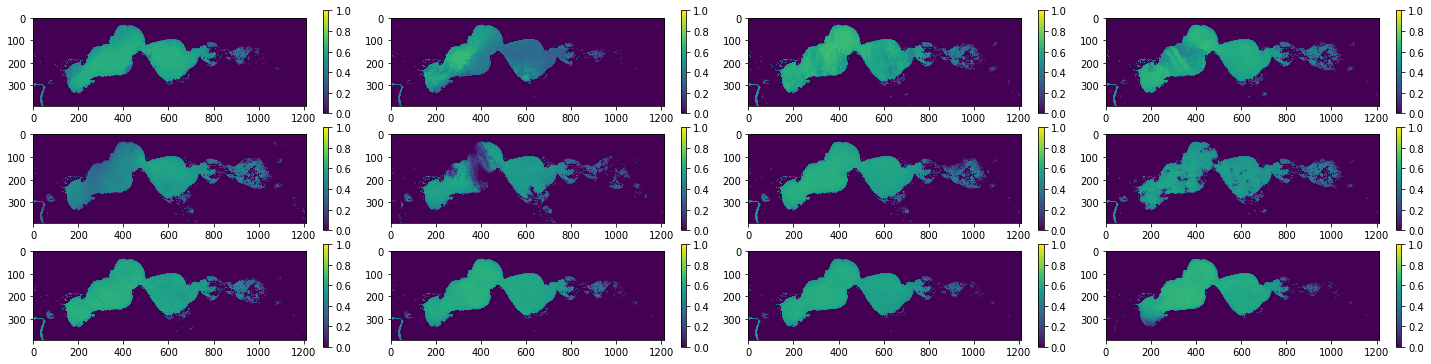

In [19]:
image_ar = eopatch.mask_timeless['NOMINAL_WATER'].shape[0] / eopatch.mask_timeless['NOMINAL_WATER'].shape[1]

# plot the NDWI at different dates
fig = plt.figure(figsize=(20,15*image_ar))

for i in range(12):
    ax = plt.subplot(3,4,i+1)
    im = ax.imshow(eopatch.data['NDWI'][i].squeeze(), vmin = 0, vmax = 1)
    ax.axis('on')
    cb = fig.colorbar(im, orientation='vertical')
    cb.ax.tick_params(labelsize=10)

plt.tight_layout(pad=0)

In [20]:
def plot_waterbody(img, date, dam_poly, dam_bbox, water_extent, water_level, 
                    color_nominal='white', color_current='xkcd:lime', ax = None):

    shape = img.shape[0:2]
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
        
    ax.imshow(img,extent=[dam_bbox.min_x,dam_bbox.max_x,dam_bbox.min_y,dam_bbox.max_y])
        
    if isinstance(dam_poly, Polygon):
        draw_poly(ax,dam_poly, color=color_nominal)
    elif isinstance(dam_poly, MultiPolygon):
        draw_multi(ax,dam_poly, color=color_nominal)
        
    if isinstance(water_extent, Polygon):
        draw_poly(ax,water_extent, color=color_current)
    elif isinstance(water_extent, MultiPolygon):
        draw_multi(ax, water_extent, color=color_current)
        


In [21]:
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat

In [22]:
import earthpy.plot as ep
from matplotlib.patches import Patch

def plot_rgb_w_water(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))
    #fig = plt.figure(figsize=(20,10))
    #ax = fig.add_subplot(111)
    
    ax.imshow(2*eopatch.data['BANDS'][..., [2, 1, 0]][idx])
    
    observed = closing(eopatch.mask['WATER_MASK'][idx,...,0], disk(1))
    nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(nominal == False, nominal)
    observed = np.ma.masked_where(observed == False, observed)
    #leg = ax.legend([plt.Rectangle((0,0),1,1)],["Estimated Water"], loc='upper left',prop={'size':12})
    #plt.plot(nominal, label='Original Geometry')
    #plt.plot(observed, label='Estimated Surface Area')
    
    #plt.legend()
    ax.imshow(nominal, cmap=plt.cm.gray)
    ax.imshow(observed, cmap=plt.cm.Reds)
    legend_labels = {"gray": "Actual Geometry", "red": "Estimated Surface Area with Water"}
    patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

    ax.legend(handles=patches,
          bbox_to_anchor=(1.35, 1), loc="upper left",
          facecolor="white")
    
    #ax.set_xlim(78.26321032,78.32777848)
    #ax.set_ylim(17.34486416,12.999590600000001)
    #fig.colorbar(c, ax = ax) 
    ax.axis('off')


In [23]:
print(eopatch.bbox.min_y,eopatch.bbox.max_y)

-12.364606440000001 -12.29529036


/Users/sachitmahajan/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)


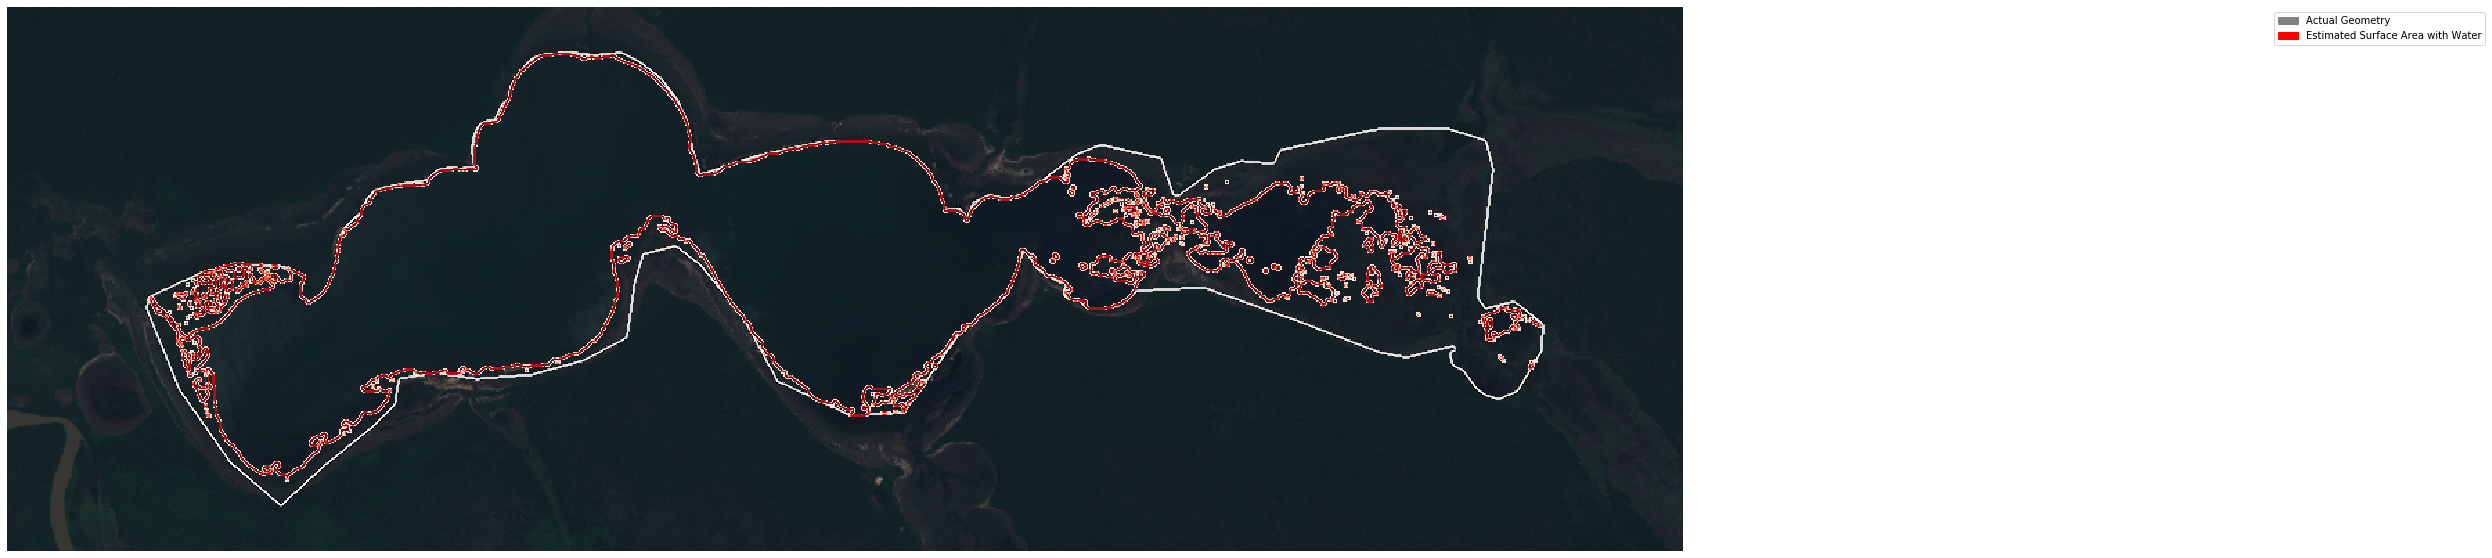

In [24]:
plot_rgb_w_water(eopatch, 0)



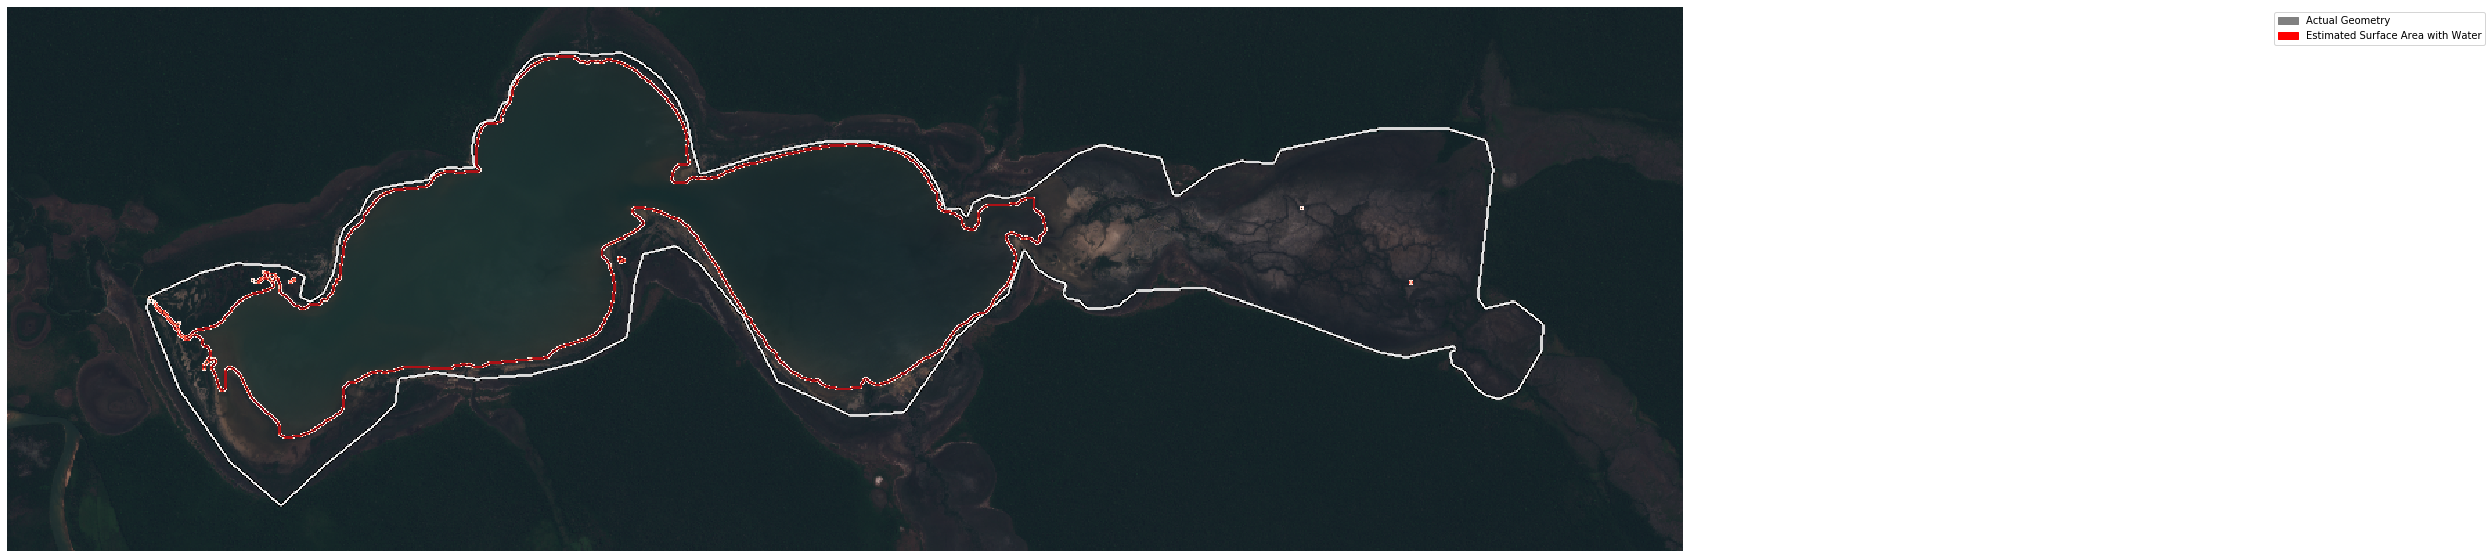

In [25]:
plot_rgb_w_water(eopatch, -1)


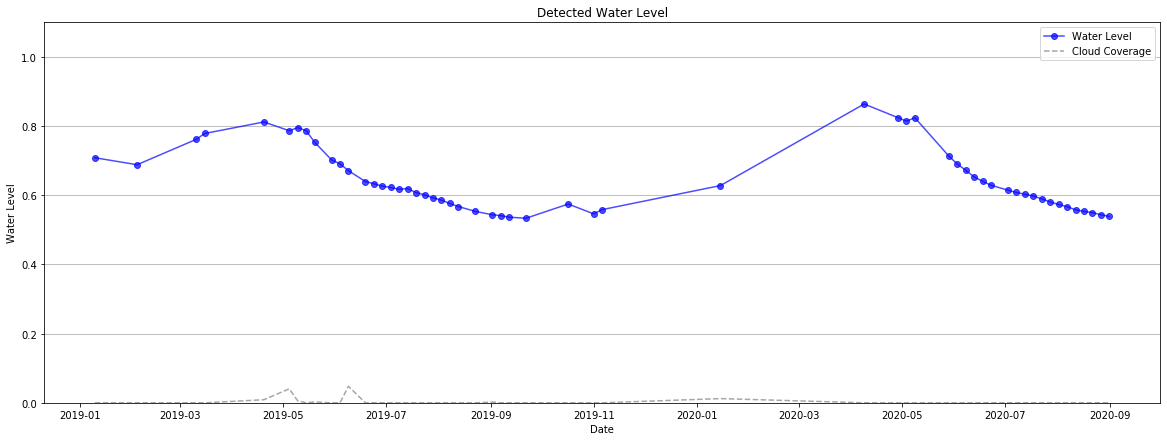

In [26]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20,7))

    dates = np.asarray(eopatch.timestamp)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['WATER_LEVEL'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            'bo-',alpha=0.7, label='Water Level')
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['COVERAGE'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            '--',color='gray',alpha=0.7, label='Cloud Coverage')
    ax.set_ylim(0.0,1.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water Level')
    ax.set_title('Detected Water Level')
    ax.grid(axis='y')
    ax.legend(loc='best')
    return ax

# plot the water level with no cloudy scene filtering (accept all clouds)
ax = plot_water_levels(eopatch, 1.0); 

In [130]:
import numpy
x = eopatch.scalar['WATER_LEVEL']
y = eopatch.scalar['COVERAGE']

In [131]:
dates = np.asarray(eopatch.timestamp)
numpy.savetxt("/Users/sachitmahajan/Desktop/date.csv", dates, fmt='%s')

In [23]:

numpy.savetxt("/Users/sachitmahajan/Desktop/level.csv", x, delimiter=",")
#numpy.savetxt("/Users/sachitmahajan/Desktop/coverage.csv", y, delimiter=",")
